<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab09_hmm2/viterbi_alignment.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 

# Viterbi Alignment - Exercise 1

In this Exercise we compute the Viterbi Alignment of real speech examples.
We use the Viterbi algorithm to distinguish between differen pronunciation options

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
torch.manual_seed(0)
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from pyspch.core.utils_x import plot_probs, get_test_file

In [4]:
### SOME UTILITIES
######################

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

def make_graph(phn_seq,phn_set,l2r=1.0,eps=0.0,skip=0.0,style="VIT",xtra_arcs=None):
    ''' 
    makes an HMM Graph to do recognition or alignment
    A transition matrix for a phone sequence (phn_seq) is created, all belonging to the alphabet phn_set
    Transition probabilities are mainly 0's and 1's 
    
    - default is make a left-to-right graph of phn_seq
        i.e. probability=1.0 on self_loop and L2R arcs
        
    - l2r:  probability on L2R arcs
    - eps:  probability on all ergodic arcs 
    - skip: probability for the skip arcs
    - xtra_arcs: list of additional arcs to be added with l2r probability
            arc indices correspond to sequence number in the phn_seq

    The end result needs to be normalized to make true probabilities out of it
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')

    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    if style == "VIT":
        init_mat = np.zeros(n_seq,dtype='float32')
        init_mat[0] = 1.0
        end_states = np.array([n_seq-1])
        # add left-to-right arcs
        for i in range(n_seq-1):
            trans_mat[i,i+1] = np.maximum(l2r,trans_mat[i,i+1])
            if i+2 < n_seq:
                trans_mat[i,i+2] = np.maximum(eps,skip)
                
    elif style == "RECO":
        init_mat = np.ones(n_seq,dtype='float32')
        end_states = np.arange(n_seq)

    # add extra arcs with the same transition probability as the LR arcs
    if xtra_arcs is not None:
        for arc in xtra_arcs:
            (i,j) =  arc[0],arc[1]
            trans_mat[i,j] = np.maximum(l2r,trans_mat[i,j])
        
    # set eps probabilities
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)
     
    return(obs_indx,trans_mat,init_mat,end_states)

def make_graph2(states,transitions=None,init=None,end=None):
    ''' 
    makes an HMM Graph over a set of states
    - states: list of defined states (required)
    - transitions: REQUIRED
    - init: list of allowed initial states (default=None=ALL)
    - end: list of allowed end states (default=None=ALL)

    Returns:
    - obs_indx:   indices of used states (referencing to state collection for observation model computations)
    - trans_mat:  transition matrix
    - init_mat:   initial matrix
    - end_states: end states (indices in HMM graph)
    
    '''
    state2idx = {lab: i for i, lab in enumerate(states)}

    if transitions is None:
        print("transitions must be specified")
        return(-1)
    n_trans = len(transitions)
    trans_ar = np.asarray(transitions)
    
    used_states = []
    for tr in transitions:
        for S in tr:
            if S not in used_states: used_states.append(S)
    n_used = len(used_states)
    used2idx = {lab: i for i, lab in enumerate(used_states)}
    
    obs_indx = np.zeros(n_used,dtype='int')
    for i  in range(n_used): 
        obs_indx[i] = state2idx[used_states[i]]
    
    if init is None: init = used_states
    init_mat = np.zeros(n_used,dtype='float32')
    for state in init:
        init_mat[ used2idx[state] ] = 1.0    

    if end is None: end = used_states
    end_states = np.asarray([ used2idx[state] for state in end ])

    # initialize transition matrix with self-loops
    trans_mat = np.eye(n_used,dtype='float32')    
    for tr in transitions:
        trans_mat[ used2idx[tr[0]], used2idx[tr[1]] ] = 1.0
           
    return(obs_indx,trans_mat,init_mat,end_states)

## 1. Load and select a Pretrained Acoustic Model

You can use 2 pretrained models trained on the TIMIT database.  They both use MFCC cepstral features and have models trained for phoneme classification (i.e. single state phonemes)

1. GMM Model
- Feature Extraction:  MFCC26=  MFCC13 + Deltas + mean-variance normalization
- model: S41_D26_G64_FULL_1.pkl  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

2. DNN Model
- Feature Extraction: MFCC39:  MFCC13 + Deltas + Delta_Deltas + mean-variance normalization
- splicing of 11 frames with stride 2  (receptive field of over 200 msec)
- model: an MLP with 3 hidden layers of size 429(IN) x 1024(L1) x 768(L2) x 512(L3) x 41(OUT)

In [33]:
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# MFCC feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # only use (the first) 26 features with gmms
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [6]:
# Some extra utilities for the DNN Model
# including an sklearn style wrapper around our torch DNN models 
# WARNING -- BE CAREFULL when combining long span receptive field in the DNNs with libhmm !! 
#    the DNN utilizes splicing and expects to see a stream of feature vectors to preform the splicing on
#    the calls will give good results for long sequences
#    this is NOT intended for frame by frame input and hence extra care is needed when combining with the libhmm library used below
#       the above problem is avoided by computing ALL observation_probs in one shot with this model before starting the trellis computations

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Posteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
        
    def predict_prob(self,X):
        proba = self.predict_proba(X)
        if self.class_prior_ is None: probs = proba
        else:
            probs = proba / self.class_prior_
            probs = probs / np.sum(probs,axis=1,keepdims=True)
        return ( probs )
        
    def predict_log_prob(self,X):
        Xp = self.predict_prob(X)
        return ( Spch.logf( Xp ) ) 

def proba_2_prob(proba,priors=None):
    ''' compute normalized likelihoods (sum = 1) from posterior probabilities
    '''
    if priors is None: return(proba)
    else:
        probs = proba / priors
        probs = probs / np.sum(probs,axis=1,keepdims=True)
    return ( probs )

##############################################################################################
#
# load an existing DNN model
#
model_path = 'models/default/mfcc13dd2mv/N5s2/'  
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}
    
setup = dotdict(setup)
model.to(device);

# the phone class priors are available in the GMM model and can be used here to convert posteriors to scaled likelihoods
# and be used with the DNN to convert from posteriors to (normalized) likelihoods 
dnn_model = DNN_model(setup=setup, model=model, priors= gmm_model.class_prior_, device=device)    
dnn_nftrs = 39

In [52]:
lexicon = {
    'the': ['dh','ah'],
    'reasons': ['r','iy','z','ah','n','z'],
    'for': ['f','ao', 'r'],
    'this': ['dh','ih','s'],
    'dive': ['dh','ay','v'],
    'seemed': ['s','iy','m','d'],
    'foolish': ['f','uw','l','ih','sh'],
    'now': ['n','aw'],
    'by' : ['b','ay'], 
    'that' : ['dh','ae','t'],
    'time' : ['t','ay','m'],
    'perhaps': ['p','er','hh','ae','p','s'],
    'something': ['s','ah','m','th','iy','ng'],
    'better': ['b','eh','t','er'],
    'can': ['k','ae','n'],
    'be': ['b','iy'],
    'done': ['d','ah','n'],
    'bricks': ['b','r','ih','k','s'],
    'are': ['aa','r'],
    'an': ['ae','n'],
    'alternative':['ao','l','t','er','n','ah','t','ih','v'],
    'friendly':['f','r','eh','n','d','l','iy'],
    'computers':['k','am','p','y','uw','t','er','z'],
    '2':['t','uw'],
    '9':['n','ay','n'],
    '5':['f','ay','v'],
    '7':['s','eh','v','ah','n']
}

def wrds_2_phns(wrds,lexicon,glue='sil'):
    '''
    expand list of words (wrds) to list of phones with glue symbol in between
    '''
    if glue is None:
        phns = []
    else:
        phns = [glue]
    for wrd in wrds:
        for phn in lexicon[wrd]:
            phns.append(phn)
        if glue is not None: phns.append(glue)
    return(phns)

## DEFINE YOUR SETUP !

The next cell defines your setup where you need to can a number of choices
1. Choose which type of acoustic model
2. Choose the file input   (possibilities: demo/friendly, timit0, timit1, ... timit4, digits/5752, .. )
3. Choose either the full file or a selected segment

The cell after that will do all the required data loading

In [40]:
USE_DNN = True
file_id = "timit2" # "demo/friendly"
USE_SELECTION = False
USE_MANUAL= True

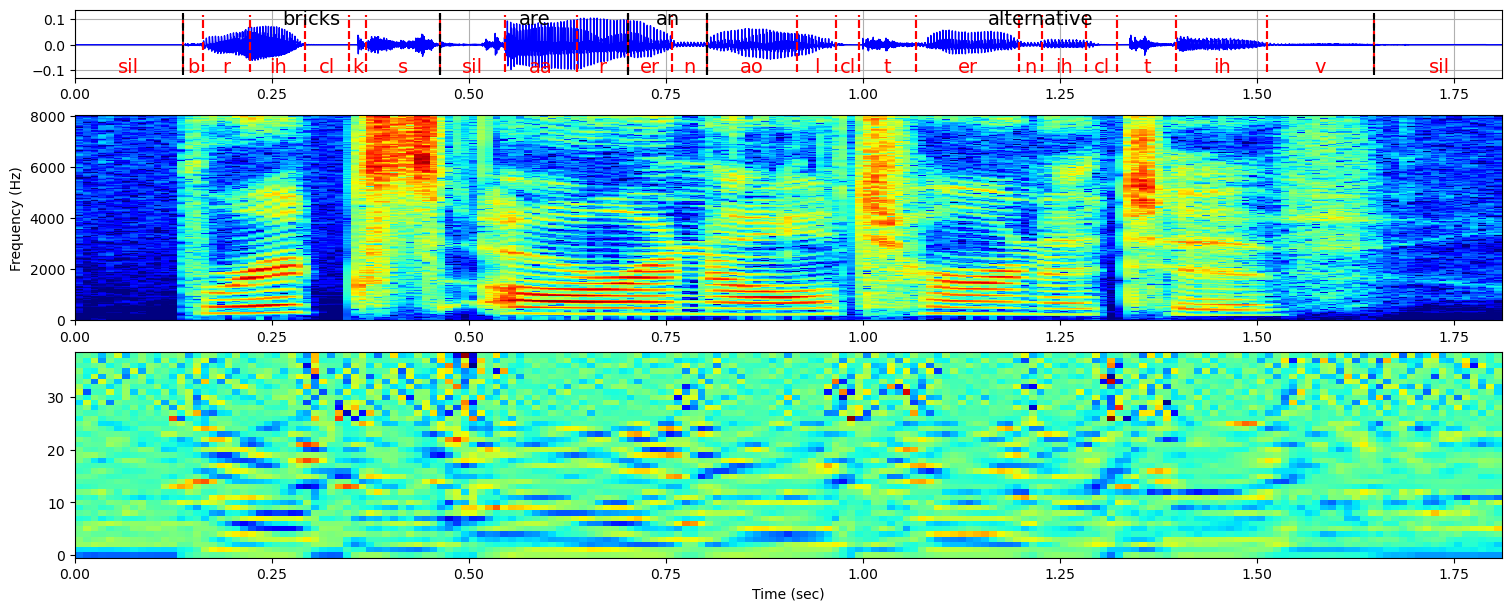

In [54]:
####################
#1. Model Selection
####################
if USE_DNN:
    acoustic_model = dnn_model
    nftrs = dnn_nftrs
else:
    acoustic_model = gmm_model
    nftrs = gmm_nftrs

####################
#2.a File Selection
####################
if file_id == 'demo/friendly':
    selection_times = np.array([0.48,1.04])
    canonical = ['sil','k',]
                 
elif file_id == 'misc/bad_bead_booed':
    selection_times = np.array([1.5,2.1])    
elif file_id == 'digits/5752':
    selection_times = np.array([0.,1.0])
elif file_id[:-1] == 'timit':
    no = int(file_id[5])
    timit_selection_times = [ [2.10,3.07], [.12,.88], [.05,.51], [0.,.85], [1.26,2.65] , [0.,1.], [0.,1.], [0.,1.] ] 
    selection_times = np.array(timit_selection_times[no])
else:
    print("file_id not recognized")

#######################################################
# 2.b Load file, transcripts and compute MFCC features
#######################################################
# load the full sentence data into the variables with a '1' at the end 
wavdata1, sr, spgdata1, ftrs1, txt1, seg_wrd1, seg_phn1 = get_test_file(file_id,feature_args=feature_args)
delta_f = (sr/2)/(spgdata1.shape[0]-1)
shift=feature_args['f_shift']
# only keep the required features for the model
ftrs1=ftrs1[:nftrs,:]
#
transcript1 = seg_phn1['seg'].tolist()
states1 = np.array(seg_phn1.index.tolist())
labels1 = pyspch.seg2lbls(seg_phn1, n_frames=ftrs1.shape[1],pad_lbl='sil')
canonical1 = wrds_2_phns(seg_wrd1['seg'].tolist(),lexicon=lexicon)

###########################################################################
# 2.c Select a short fragment from the full sentence for the demo/exercise
##########################################################################
# make a selection of a short fragment into the variables ending in '2' 
# making  a selection is done for visualization purposes to restrict to max +- 100 frames and +- 15 phonemes in the plots
# you can override the segment selection times as shown in the following line
# selection_times = np.array([0.51,.92])
frames= (selection_times/shift).astype('int')
samples = (selection_times*sr).astype('int')
sample_sel = slice(samples[0],samples[1])
frame_sel = slice(frames[0],frames[1])
#
wavdata2 = wavdata1[sample_sel]
spgdata2 = spgdata1[:,frame_sel]
ftrs2 = ftrs1[:,frame_sel]
#
seg_phn2 = seg_phn1[(seg_phn1['t0']<frames[1]*shift) & (seg_phn1['t1']>frames[0]*shift)]
seg_phn2['t0'] = seg_phn2['t0']-selection_times[0]
seg_phn2['t1'] = seg_phn2['t1']-selection_times[0]
seg_wrd2 = seg_wrd1[(seg_wrd1['t0']<frames[1]*shift) & (seg_wrd1['t1']>frames[0]*shift)]
seg_wrd2['t0'] = seg_wrd2['t0']-selection_times[0]
seg_wrd2['t1'] = seg_wrd2['t1']-selection_times[0]
canonical2 = wrds_2_phns(seg_wrd2['seg'].tolist(),lexicon=lexicon)
#
states2 = np.array(seg_phn2.index.tolist())
transcript2 = np.array(transcript1)[states2]
labels2 = pyspch.seg2lbls(seg_phn2, n_frames=ftrs2.shape[1],pad_lbl='sil')

###################################################################################
#  3. Use either selection data or the full sentence data based on global settings
###################################################################################
if USE_SELECTION:
    wavdata, spgdata, ftrs, labels, seg_phn, seg_wrd, transcript, states, canonical = wavdata2, spgdata2, ftrs2, labels2, seg_phn2, seg_wrd2, transcript2, states2, canonical2
else:
    wavdata, spgdata, ftrs, labels, seg_phn, seg_wrd, transcript, states, canonical = wavdata1, spgdata1, ftrs1, labels1, seg_phn1, seg_wrd1, transcript1, states1, canonical1

#################################################################################################
# 4. SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=delta_f,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=0, ypos=.1, color='r',size=14) 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='k',size=14) 
display(fig)
display(Audio(data=wavdata,rate=sr))

### Frame Recognition

In frame recognition each feature vector is treated independently.  It consists of 2 simple steps:   
1. compute the class probabilities for each feature vector
2. recognize by finding the maximum amongst all classes

In [30]:
frame_proba = acoustic_model.predict_proba(ftrs.T)
# normalized frame "observation" likelihoods can be computed fromt the posterior probabilities 
frame_probs = proba_2_prob(frame_proba,priors=gmm_model.class_prior_)
frame_logprobs = Spch.logf(frame_probs)

In [111]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# evaluate frame based recognition wrt. manual segmentations
y_frame_idx = np.argmax(frame_proba, axis=1)
#y_frame_idx = np.argmax(frame_probs, axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
t = np.arange(len(y_frame_lab))*shift+0.5*shift
y_frame_ldf = pd.DataFrame({'t':t,'lbl':y_frame_lab})
y_frame_seg = pyspch.lbls2seg(y_frame_lab)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)) )
#

Frame Recognition Rate (for full utterance): 26.79 %


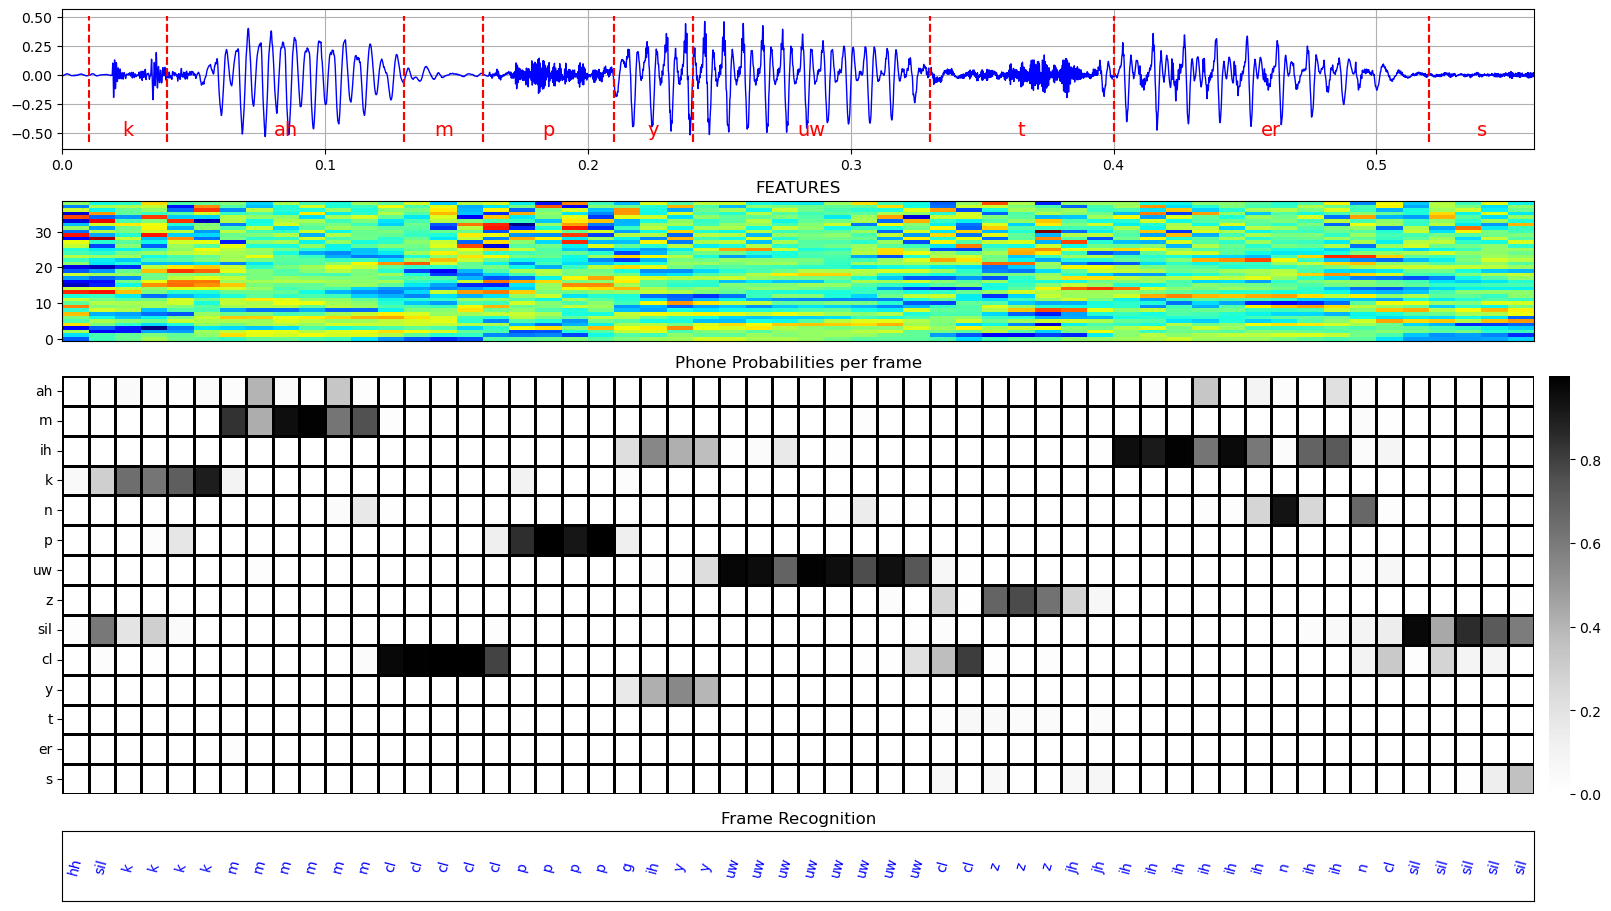

In [112]:
# show the outputs of the most likely phones and at least all phones in the transcript, resorted for order in alphabet
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba,axis=0))[::-1][0:top_k]
indx_sel = np.sort(indx_sel)
phn_sel = [phn_set[i] for  i in indx_sel]
phn_sel,indx_sel = select_phones_idx((phn_sel,transcript),phn_set,SORTED=False)
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,.5],
            sample_rate=sr, figsize=(16,9),  img_ftrs=[None,None],img_labels=[None,None])

(iax_wav, iax_ftr, iax_prob, iax_frame) = (0,1,2,3)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
#fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_title("FEATURES")
fig.axes[iax_ftr].set_xticks([])
plot_probs(frame_proba[:,indx_sel], phn_sel,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Phone Probabilities per frame") 
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10,txtargs={'rotation':75},title="Frame Recognition")

#fig.axes[iax_frame].axis('off')
fig.axes[iax_frame].set_xticks([])
fig.axes[iax_frame].set_xlabel("")
display(fig)

### Viterbi Alignment against a REFERENCE transcription
For a Viterbi alignment we use a Trellis setup.
If we want to align our data with a given transcription, then we may enforce a strict left-to-right arrangement of HMM states corresponding to the transcription.

It consists of 3 steps:   
1. compute the observation probabilities for each state given the feature vector (we compute likelihoods from the probabilities used for frame recognition)
2. complete the trellis (left to right) with the state sequence on the vertical and frame likelihoods on the horizontal axis .  Note that the HMM model uses 'likelihoods' and '(posterior) probabilities'
3. Find the Viterbi alignment by backtracking on the trellis

In the code below we use manual phone labels as the reference transcription.
In the end we compute the frame level agreement with our given 'manual' alignment.  The correspondence will likely NOT be 100%.  
But this is not problematic.  Any manual transciption / alignment is far from perfect.  You will observe that the automatic alignments are in general of high quality.

In [113]:
# Viterbi alignment with feeding the observation probabilities directly to the model
l2r = 1
skip=0
obs_indx, trans_mat,init_mat,end_states = make_graph(transcript,phn_set,l2r=l2r,skip=skip)
#####
observations = frame_logprobs
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
hmm1.set_probstyle('log')
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(observations)
# recognize from the trellis
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Frame level agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Frame level agreement with manual alignment: 62.50 %


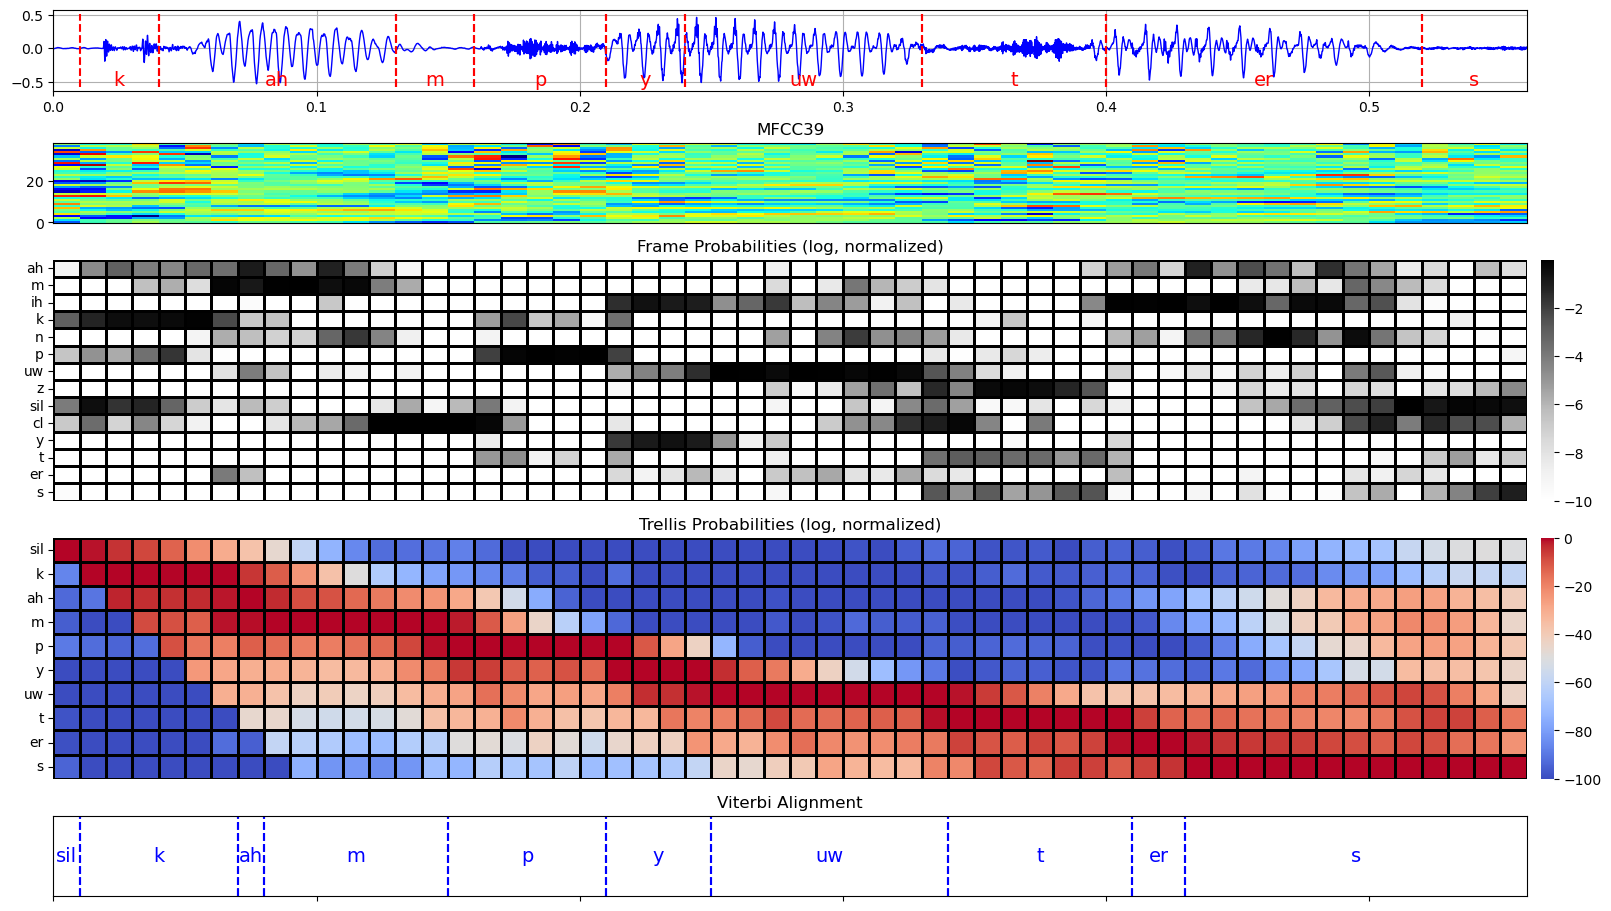

In [114]:
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftr, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
#fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_xticks([])
fig.axes[iax_ftr].set_title("MFCC39")
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[:,indx_sel],phn_sel,fig=fig, cmap='Greys',iax=iax_prob,title="Frame Probabilities (log, normalized)",
          vmin=-10, style="img" ) # style="lin",yrange=[-10.,0]  )
#
trel_probs = trellis1.probs
plot_probs(trel_probs,fig=fig,cmap='coolwarm',labels=transcript,iax=iax_trel,title="Trellis Probabilities (log, normalized)",
          style="img",vmin=-100.) 
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#00F',size=14,title="Viterbi Alignment")
#
display(fig)

### Viterbi Alignment against a set of potential transcription variants
We can use an almost equal setup to do a constrained recognition to find the precise pronunciation of words or sentences.
In this setup we use a transcription as reference but add potential transitions, e.g. to skip optional phones are to set potential pronunciations in parallel.

In [73]:
# In the example below we try to find if the pronounced word was "BRICKS" or "BRITS"
# Remark that we use a single silence state 
transitions = [['sil','b'],['b','r'],['r','ih'],['ih','k'],['ih','t'],['k','s'],['t','s'],['s','sil']]
init = ['sil']
end = ['sil']
obs_indx, trans_mat,init_mat,end_states = make_graph2(phn_set, transitions, init=init, end=end)
state_labels = [ phn_set[i] for i in obs_indx ]
print(state_labels)

['sil', 'b', 'r', 'ih', 'k', 't', 's']


In [74]:
# Viterbi alignment with feeding the observation probabilities directly to the model

####
observations = frame_logprobs
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=state_labels,transmat=trans_mat,initmat=init_mat,end_states=end_states)
hmm1.set_probstyle('log')
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(observations)
# recognize from the trellis
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Frame level agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Frame level agreement with manual alignment: 73.91 %


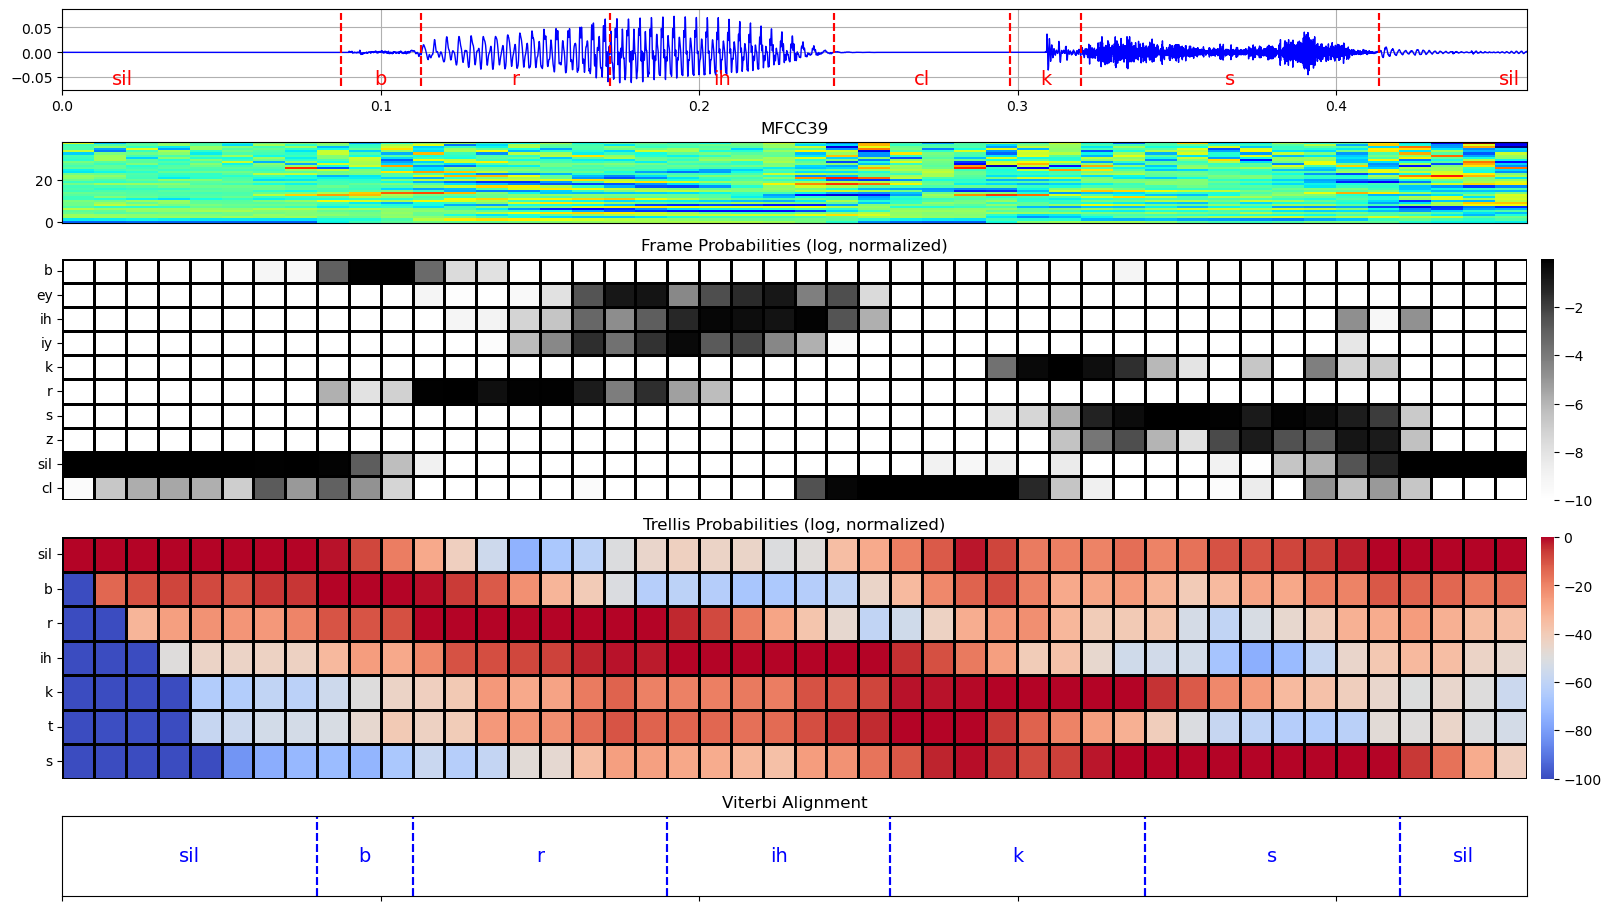

In [75]:
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftr, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
#fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_xticks([])
fig.axes[iax_ftr].set_title("MFCC39")
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[:,indx_sel],phn_sel,fig=fig, cmap='Greys',iax=iax_prob,title="Frame Probabilities (log, normalized)",
          vmin=-10, style="img" ) # style="lin",yrange=[-10.,0]  )
#
trel_probs = trellis1.probs
plot_probs(trel_probs,fig=fig,cmap='coolwarm',labels=state_labels,iax=iax_trel,title="Trellis Probabilities (log, normalized)",
          style="img",vmin=-100.) 
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#00F',size=14,title="Viterbi Alignment")
#
display(fig)

### Phone Recognition 
We can use our trellis to do recognition as well, i.e. to find the best possible state sequence that might underly the data.
In order to use the trellis for recognition, we need to define all possible transition probabilities between states.
In this notebook we use single state phone models, making the graph construction rather trivial.
The graph construction module that we use here allows to specify probabilities for ergodic (any-to-any) transitions, the left-to-right transitions
and skip transitions.  The self-loop probability is set to '1.0'.

In [76]:
l2r = 0.
skip=0.
eps=.001
trel_phones = np.unique(transcript) # transcript
trel_indx = [ phn2idx[ph] for ph in trel_phones ]
obs_indx, trans_mat,init_mat,end_states = make_graph(trel_phones,phn_set,eps=eps,skip=skip,style="RECO")
#
# for the HMM we use likelihoods instead of posteriors
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=trel_phones,transmat=trans_mat,initmat=init_mat,end_states=end_states)
hmm2.set_probstyle('log')
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(frame_logprobs)
# recognize from the trellis
y_reco_lbl = hmm2.states[trellis2.backtrace()]
y_reco_ldf = pd.DataFrame({'t':t,'lbl':y_reco_lbl})
y_reco_seg = Spch.lbls2seg(y_reco_lbl)
n_corr = np.sum([y_reco_lbl[i] == labels[i] for i in range(len(y_reco_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_reco_lbl)))

Agreement with manual alignment: 86.96 %


Levenshtein Distance:  0 / 8 
Phone Error Rate:  0.00% 
['sil' 'b' 'r' 'ih' 'cl' 'k' 's' 'sil']
['sil' 'b' 'r' 'ih' 'cl' 'k' 's' 'sil']


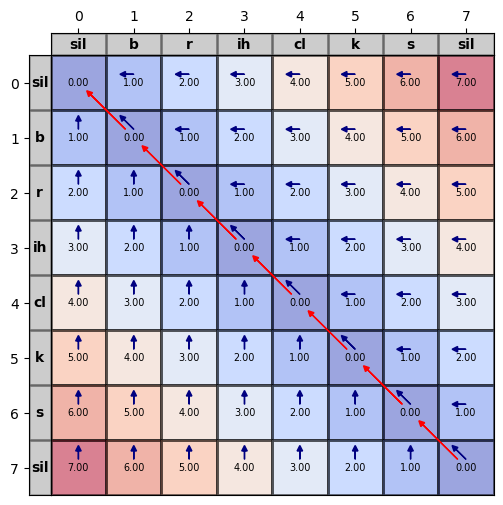

In [77]:
from pyspch import dtw
y = np.array(seg_phn['seg'])
x = np.array(y_reco_seg['seg'])
lev_dist,trace,ld,cd,bptrs = dtw.dtw(x,y,trans="LEV",p='hamming',result='details')
print("Levenshtein Distance:  %d / %d " %(lev_dist,len(y)))
print("Phone Error Rate:  %.2f%% " %(100.*lev_dist/len(y)))
print(y), print(x)
plt_args = {'ftr_scale':.05,'fig_width':6.,'ftr_args':{'alpha':.2,'cmap':'Greys','fontweight':'bold'}, 
           'xy_annot':True,'xy_args':{'cmap':'coolwarm','alpha':.5,'text_size':'x-small'} }
display(dtw.plot_trellis(x=x,y=y,xy_mat=cd,trace=trace,bptrs=bptrs,**plt_args))

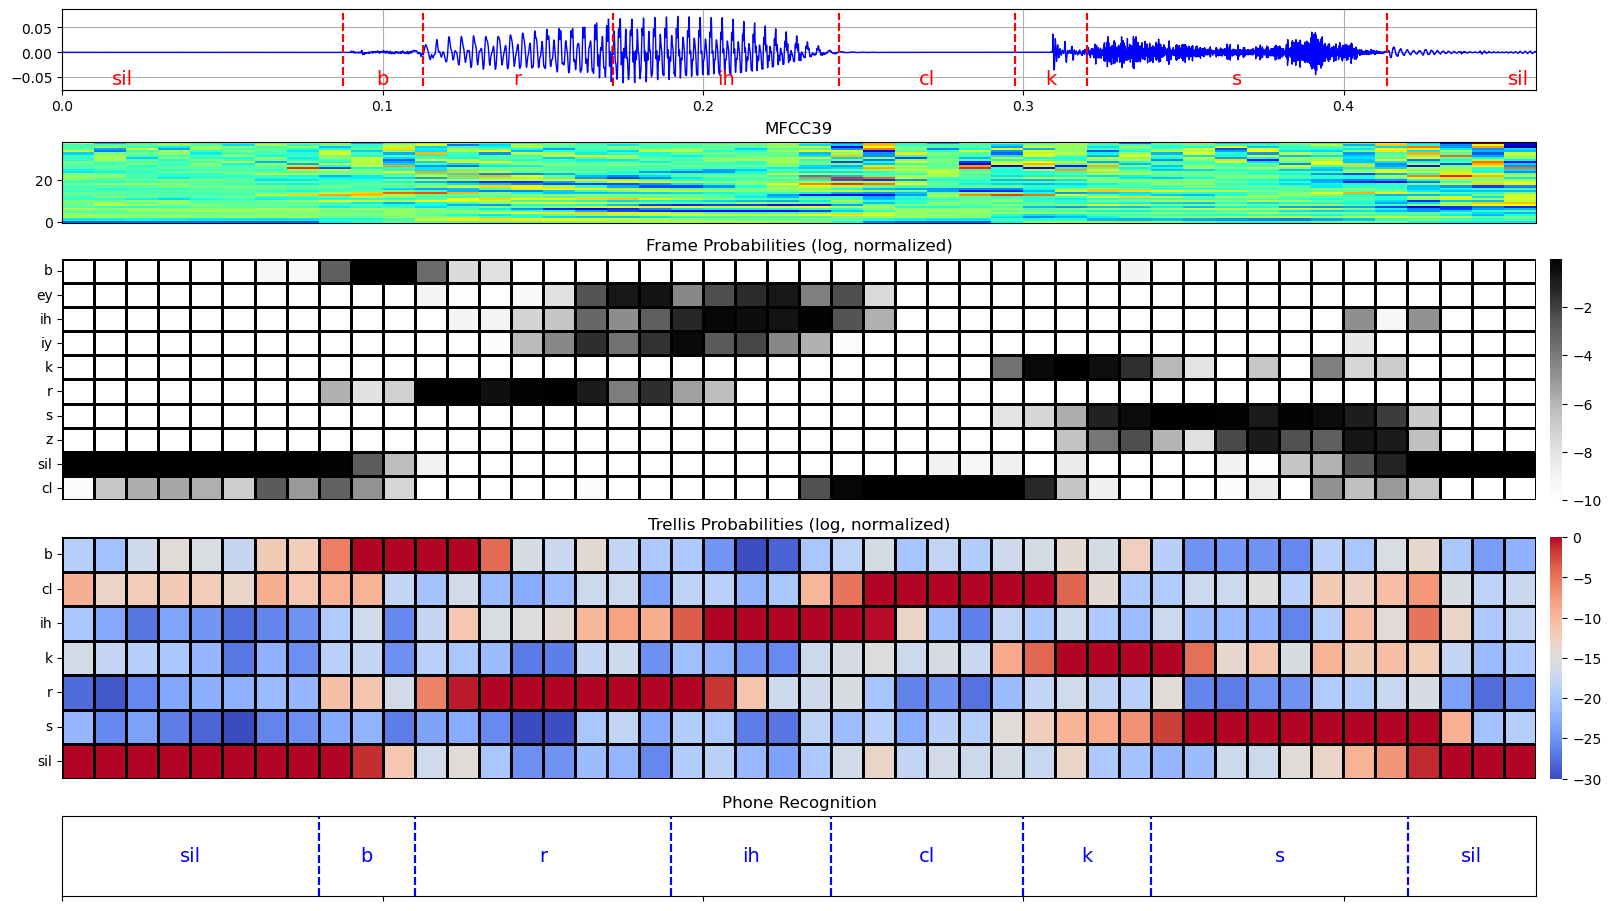

In [78]:
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftr, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
#fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_title("MFCC39")
fig.axes[iax_ftr].set_xticks([])
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[:,indx_sel],phn_sel,vmin=-10.,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Frame Probabilities (log, normalized)") 
#
trel_probs = trellis2.probs
plot_probs(trel_probs,labels=trel_phones,vmin=-30.,fig=fig,cmap='coolwarm',iax=iax_trel,style="img",title="Trellis Probabilities (log, normalized)",
           annot=False)
#fig.add_seg_plot(y_reco_ldf,iax=iax_vit,ypos=.75,color='#000',size=10)
fig.add_seg_plot(y_reco_seg,iax=iax_vit,ypos=.5,color='#00F',size=14,title="Phone Recognition")
#fig.axes[iax_vit].set_ylabel('Recognition')
#
display(fig)

### Plot Selected Segments and Phones

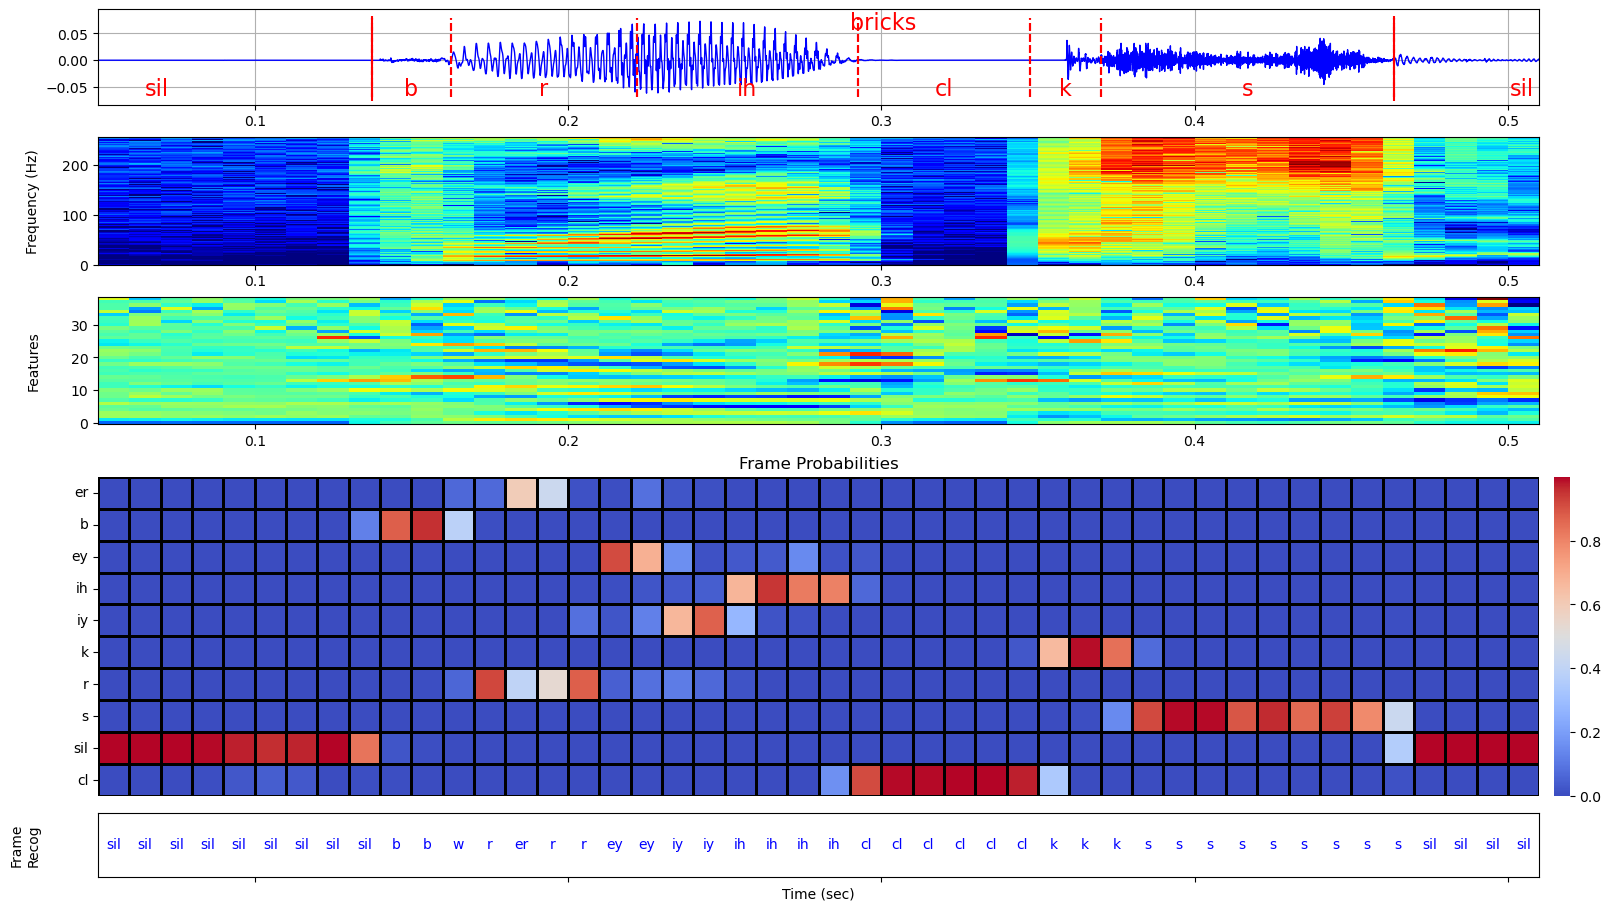

Frame Recognition Rate: 38/46 (82.61%)


In [121]:
# make a selection of phones to plot
# include the most likely outputs and the phones in the transcriptions
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba[frame_sel,:],axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
phn_sel, indx_sel = select_phones_idx((seg_phn2['seg'],phn_sel,['sil']),phn_set,SORTED=True)

# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,2,5,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[ftrs,None,None],img_labels=['Features',None,None])
(iax_wav, iax_spg, iax_ftr, iax_prob, iax_frame, iax_ref) = (0,1,2,3,4,5)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r') # seg
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, Lines=True, color='r')

plot_probs(frame_proba[frame_sel,indx_sel], phn_sel,fig=fig, cmap='coolwarm',iax=iax_prob, vmin=None, x0=frames[0]*shift, style="img", title="Frame Probabilities")
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.axes[iax_frame].set_ylabel('Frame\nRecog')

display(fig)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(frames[0],frames[1])])
n_frames = (frames[1]-frames[0])
print("Frame Recognition Rate: %d/%d (%.2f%%)" % (n_corr,n_frames,100.*n_corr/n_frames))

In [122]:



fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=ftrs,spglabel="MFCC39",dy=1,frames=frames,sample_rate=sr,figsize=(15,10),row_heights=[1,1,4,1,4,1,1],
                  img_ftrs=[None,None,None])
(iax_wav, iax_spg, iax_prob, iax_frame, iax_trel, iax_vit, iax_ref) = (0,1,2,3,4,5,6)
obs_probs = np.log(frame_proba) 
obs_probs = frame_proba
trel_probs = trellis1.probs
plot_probs(obs_probs[frame_sel,indx_sel],fig=fig,iax=iax_prob,labels=phn_sel,cmap="Greys",style="img",title="Observation Probabilities (log, normalized)")
plot_probs(trel_probs[frame_sel,states2],fig=fig,cmap='coolwarm',labels=transcript_sel,iax=iax_trel,style="img",title="Trellis Probabilities (log, normalized)",annot=True)
#fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

#fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')

fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(y_vit_ldf,iax=iax_vit,ypos=.75,color='#000',size=10)
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.25,color='#00F',size=14)
fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=.25,color='r',size=14,Lines=False)
fig.axes[iax_frame].set_ylabel('FRAME')
fig.axes[iax_vit].set_ylabel('VIT')
fig.axes[iax_ref].set_ylabel('REF',color='r')
fig.axes[iax_frame].set_xlabel("")
#fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=0.2,color='b',title='Reference Alignment')
display(fig)


IndexError: index 7 is out of bounds for axis 1 with size 7

In [21]:
pd.set_option('display.float_format', '{:.2f}'.format)
i1 = 60
i2 = 70
trellis = trellis1
obs_probs = frame_logprobs
trel_probs = trellis.probs
dfo1 = pd.DataFrame(obs_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
dft1 = pd.DataFrame(trel_probs[i1:i2,states2].T,index=transcript_sel,columns=np.arange(i1,i2))
dfo2 = pd.DataFrame(obs_probs[i1:i2,:].T,index=phn_set,columns=np.arange(i1,i2))
dft2 = pd.DataFrame(trel_probs[i1:i2,:].T,index=transcript,columns=np.arange(i1,i2))

In [22]:
display(dfo1, dft1)

,60,61,62,63,64,65,66,67,68,69
ah,-12.11,-14.83,-17.47,-15.50,-12.43,-14.01,-9.51,-10.57,-6.94,-12.29
er,-19.82,-29.46,-35.29,-25.56,-21.34,-23.78,-21.81,-26.50,-16.41,-12.29
m,-1.35,-3.77,-9.03,-14.14,-17.25,-19.79,-19.33,-25.40,-15.06,-10.74
ih,-17.98,-23.31,-33.99,-30.92,-23.03,-21.24,-17.37,-16.97,-9.06,-3.22
k,-13.95,-13.10,-15.31,-11.42,-5.61,-1.66,-3.15,-2.18,-1.29,-4.67
n,-2.13,-4.94,-3.58,-7.92,-12.09,-15.25,-18.12,-20.04,-11.45,-11.97
p,-25.18,-22.14,-18.73,-7.49,-0.98,-6.22,-0.68,-6.10,-2.72,-8.43
s,-24.42,-22.99,-17.91,-13.17,-10.20,-12.59,-10.19,-5.63,-7.35,-13.35
t,-8.83,-8.50,-10.01,-10.73,-3.58,-1.70,-7.55,-2.66,-4.60,-3.82
uw,-18.14,-16.24,-19.14,-29.71,-27.29,-24.17,-16.87,-20.25,-7.88,-4.88


,60,61,62,63,64,65,66,67,68,69
sil,-66.53,-64.99,-61.10,-54.81,-57.53,-59.42,-68.62,-75.09,-83.09,-93.46
k,-53.77,-63.10,-69.38,-65.03,-59.44,-52.98,-55.45,-51.52,-50.09,-51.59
ah,-35.64,-46.69,-55.14,-63.15,-74.60,-67.24,-61.81,-59.91,-55.74,-59.21
m,0.00,0.00,0.00,-6.65,-22.92,-36.49,-55.14,-74.44,-72.26,-63.32
p,-23.83,-18.37,-9.70,0.00,0.00,0.00,0.00,0.00,0.00,-5.27
y,-36.42,-42.39,-38.89,-26.69,-16.02,-5.11,-14.01,-20.10,-1.88,0.00
uw,-47.60,-48.89,-52.50,-61.11,-53.00,-33.98,-21.30,-28.15,-25.26,-3.60
t,-48.08,-52.33,-49.87,-53.11,-55.71,-48.48,-40.85,-17.85,-19.73,-20.39
er,-64.13,-73.77,-78.59,-67.94,-73.48,-73.28,-69.62,-61.24,-31.54,-28.85
s,-73.70,-83.35,-82.65,-84.27,-77.16,-79.85,-82.79,-69.14,-65.87,-41.72


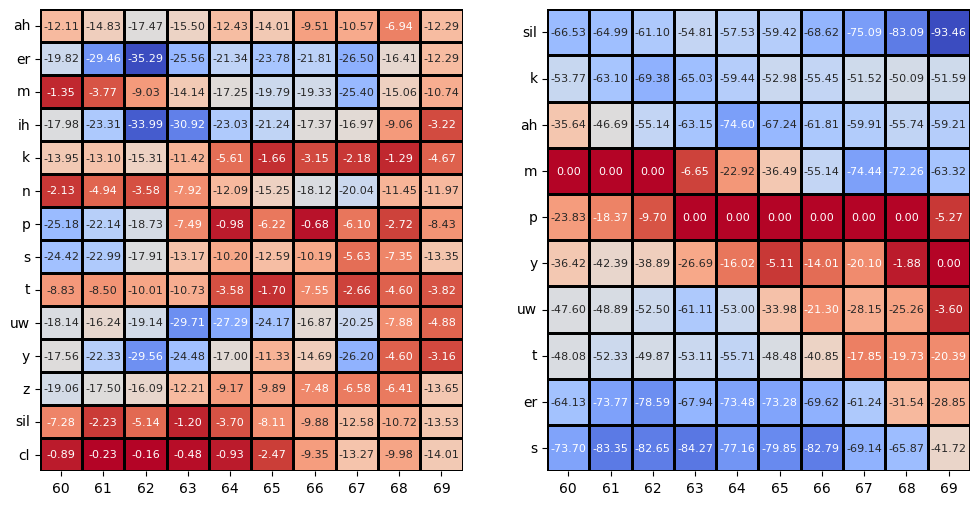

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

kwargs = {"cmap":"coolwarm","fmt":".2f","linewidths":1,"linecolor":'k',"annot":True,"annot_kws":{"fontsize":8},'cbar':False,'square':False}
sns.heatmap(dfo1,ax=ax[0],**kwargs)
sns.heatmap(dft1,ax=ax[1],**kwargs)
#cmap="coolwarm",fmt=".2f",linewidths=1,linecolor='k',annot=True) #, ax=ax, yticklabels=labels, cmap=cmap,vmin=vmin,,cbar_kws={'pad':0.0})
for axx in ax: axx.set_yticklabels(axx.get_yticklabels(), rotation=0)
#ax.set_xticks([])

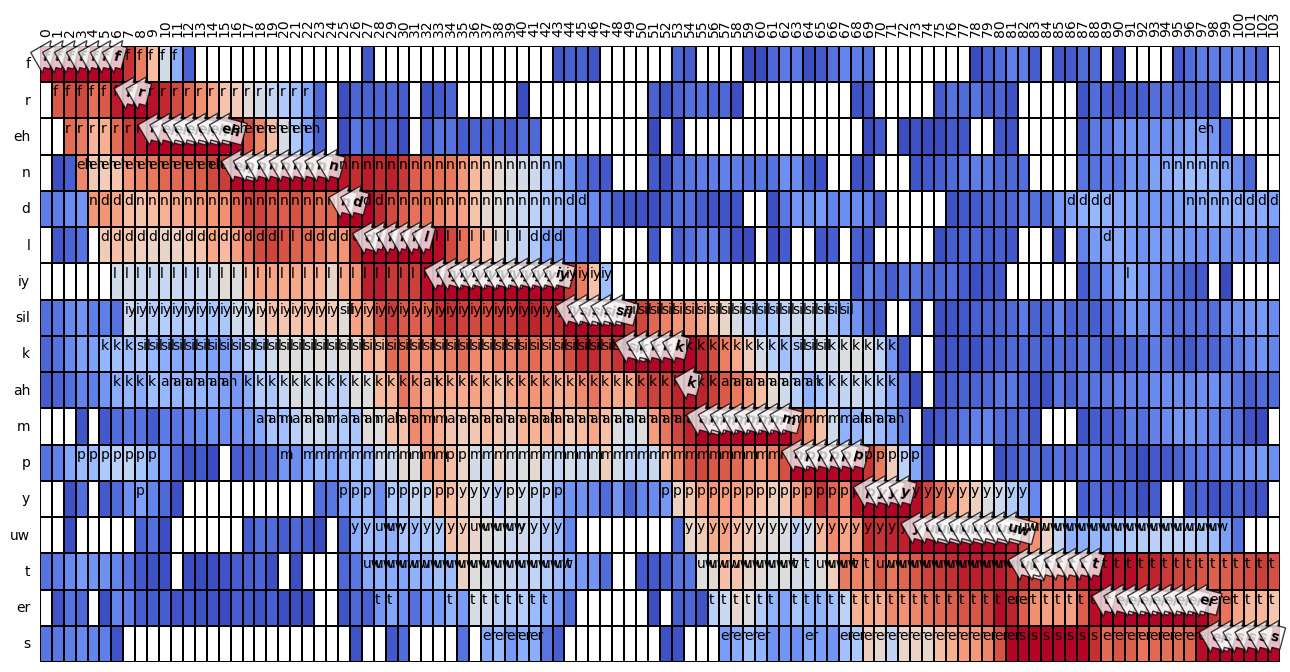

In [20]:
trellis1.plot_trellis(figsize=(16,8),vmin=-100,plot_values=False,plot_backptrs=True,plot_alignment=True,cmap="coolwarm")

In [23]:
trellis.probs[0:5].T

array([[   0.   ,    0.   ,    0.   ,    0.   ,    0.   ],
       [-109.592,  -11.592,   -9.353,   -7.941,  -15.777],
       [-108.137, -100.254,  -14.886,  -18.146,  -32.278],
       [-100.828,  -99.401,  -95.535,  -21.08 ,  -39.324],
       [ -88.59 ,  -88.525,  -85.129,  -82.769,  -24.147],
       [-107.574,  -97.601,  -94.334,  -90.314, -100.305],
       [-111.455, -107.259, -105.903, -108.182, -124.959],
       [ -92.146,  -90.323,  -85.486,  -82.628,  -88.098],
       [ -93.769,  -90.798,  -85.158,  -79.502,  -79.559],
       [ -96.095,  -94.458,  -91.927,  -87.021,  -88.241],
       [-108.743, -105.632, -102.827,  -98.014, -106.815],
       [ -91.208,  -87.385,  -77.843,  -71.433,  -71.337],
       [-108.563, -101.323,  -98.586,  -91.927, -102.156],
       [-114.245, -107.864,  -98.893, -103.224, -118.919],
       [ -90.873,  -89.269,  -85.315,  -80.84 ,  -82.496],
       [-109.522,  -97.835,  -90.829,  -93.34 , -104.113],
       [ -90.546,  -90.176,  -88.044,  -85.201,  -86.764

In [24]:
trellis.obs_probs[0:5].T

array([[ -2.268,  -3.369,  -9.709,  -9.801,  -4.276],
       [-22.059, -14.961, -19.062, -17.742, -20.052],
       [-20.605, -13.822, -13.003, -18.594, -28.613],
       [-13.296, -12.969, -15.444, -15.995, -25.453],
       [ -1.057,  -3.304,  -6.313,  -7.441,  -7.343],
       [-20.041, -12.38 , -15.518, -14.986, -21.812],
       [-23.922, -20.827, -25.812, -28.183, -39.434],
       [ -4.614,  -3.891,  -5.394,  -6.943,  -9.746],
       [ -6.236,  -4.366,  -5.066,  -4.145,  -4.333],
       [ -8.562,  -8.026, -11.835, -11.665, -13.014],
       [-21.21 , -19.199, -22.735, -18.015, -24.069],
       [ -3.676,  -0.953,  -0.166,  -3.392,  -4.179],
       [-21.03 , -14.891, -20.91 , -23.885, -34.998],
       [-26.712, -21.432, -18.802, -23.224, -33.394],
       [ -3.341,  -2.837,  -5.756,  -5.326,  -5.931],
       [-21.99 , -11.403, -11.269, -17.826, -27.548],
       [ -3.013,  -3.744,  -7.952,  -6.959,  -5.838]])

In [30]:
trellis.backptrs[0:5].T

array([[ 0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0],
       [-1, -1,  1,  1,  1],
       [-1, -1, -1,  2,  2],
       [-1,  4,  4,  4,  3],
       [-1,  4,  4,  4,  4],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1,  7,  7],
       [-1, -1, -1,  8,  8],
       [-1, -1, -1,  8,  8],
       [-1, -1, -1, -1,  9],
       [-1, -1, 11, 11, 11],
       [-1, -1, 11, 11, 11],
       [-1, -1, -1, -1, -1],
       [-1, -1, 14, 14, 14],
       [-1, -1, 14, 14, 14],
       [-1, -1, -1, 16, 16]])

In [59]:
1.e-39 / 100

9.999999999999999e-42

In [60]:
np.exp( 2 * np.log(1.e-39) )

1.0000000000000061e-78

In [29]:
trellis.__dict__

{'hmm': <pyspch.stats.libhmm.HMM at 0x1fb1e84f4f0>,
 'style': 'Viterbi',
 'Normalize': True,
 'n_samples': 104,
 'obs_probs': array([[ -2.268, -22.059, -20.605, ...,  -3.341, -21.99 ,  -3.013],
        [ -3.369, -14.961, -13.822, ...,  -2.837, -11.403,  -3.744],
        [ -9.709, -19.062, -13.003, ...,  -5.756, -11.269,  -7.952],
        ...,
        [ -7.311, -24.896, -28.635, ...,  -2.01 , -26.082,  -4.013],
        [ -9.43 , -22.776, -31.127, ...,  -2.274, -27.793,  -4.276],
        [-13.117, -26.761, -33.457, ...,  -3.194, -31.985,  -0.696]]),
 'probs': array([[   0.   , -109.592, -108.137, ...,  -90.873, -109.522,  -90.546],
        [   0.   ,  -11.592, -100.254, ...,  -89.269,  -97.835,  -90.176],
        [   0.   ,   -9.353,  -14.886, ...,  -85.315,  -90.829,  -88.044],
        ...,
        [ -91.053, -108.637, -114.422, ...,   -8.905,  -32.977,    0.   ],
        [ -94.955, -108.301, -116.652, ...,   -6.903,  -32.422,    0.   ],
        [-102.222, -115.866, -122.562, ...,   -9.